In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum
import pandas as pd
# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm
from os import makedirs, path as op
# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection, SHConfig, BBoxSplitter
from utils import (SentinelHubValidData, CountValid, NormalizedDifferenceIndex, ConcatenateData, ValidDataFractionPredicate)

In [2]:
# Folder where data for running the notebook is located
DATA_FOLDER = os.path.join('.', 'example_data')

# Folder where data will be stored
EOPATCH_FOLDER = os.path.join('.', 'eopatches', 'eopatches')
EOPATCH_SAMPLES_FOLDER = os.path.join('.', 'eopatches_sampled')
RESULTS_FOLDER = os.path.join('.', 'results')
os.makedirs(EOPATCH_FOLDER, exist_ok=True)
os.makedirs(EOPATCH_SAMPLES_FOLDER, exist_ok=True)
os.makedirs(RESULTS_FOLDER, exist_ok=True)

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
countries = gpd.read_file('data.gpkg')
country = countries[countries.SOVEREIGNT.str.contains('Slovenia')]
# Convert CRS to UTM_33N
country_crs = CRS.UTM_33N

if country.crs != country_crs:
    country = country.to_crs(crs=country_crs.pyproj_crs())

country_shape = country.geometry.tolist()[-1]
width_pix = int((country_shape.bounds[2]-country_shape.bounds[0])/10)
height_pix = int((country_shape.bounds[3]-country_shape.bounds[1])/10)

bbox_splitter = BBoxSplitter([country_shape], country_crs, (25, 17))
bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]

df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
common_crs = bbox_splitter.bbox_list[0].crs
gdf = gpd.GeoDataFrame(df, crs=common_crs.pyproj_crs(), geometry=geometry)

In [6]:
width_pix

24218

In [4]:
ID = 100
# Obtain surrounding 5x5 patches
patchIDs = []
for idx, (bbox, info) in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)

# Check if final size is 3x3
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (useful for plotting)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = 'ukraine_500x500.gpkg'
gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver='GPKG')

In [5]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patchIDs)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f'eopatch_{i}')
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [14]:
eopatch = sampled_eopatches[12]
width, height = eopatch.mask_timeless['LULC'].squeeze().shape

In [14]:
index, radius = 190, 1.5
r = int(radius)
row, column = index // width, index % width
row, column

(1, 1)

In [73]:
# определяем координаты пикселя
x = np.arange(max(column - r, 0), min(column + r + 1, width))
y = np.arange(max(row - r, 0), min(row + r + 1, height))

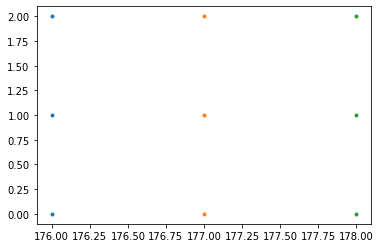

In [74]:
X,Y = np.meshgrid(x,y)
plt.plot(X,Y, marker='.', linestyle='none')
plt.show()

In [75]:
R = np.sqrt(((X - column)**2 + (Y - row)**2))
R

/home/vlas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.41421356, 1.        , 1.41421356],
       [1.        , 0.        , 1.        ],
       [1.41421356, 1.        , 1.41421356]])

In [76]:
mask = R < radius

In [77]:
X[mask], Y[mask]

(array([176, 177, 178, 176, 177, 178, 176, 177, 178]),
 array([0, 0, 0, 1, 1, 1, 2, 2, 2]))

In [78]:
# соседние пиксели
Y[mask]*width + X[mask]

array([176, 177, 178, 365, 366, 367, 554, 555, 556])

In [20]:
from skimage import util
import image

img = eopatch.mask_timeless['LULC']
eopatch = sampled_eopatches[0]
width, height = eopatch.mask_timeless['LULC'].squeeze().shape

for i in range(0, width):
    for j in range(0, height):
        pixel = img.get_pixel(j, i)
        windows = util.view_as_windows(pixel, (3, 3, 1))
        out = windows.reshape(-1, 3 * 3 * 1)
out.shape      

AttributeError: 'numpy.ndarray' object has no attribute 'get_pixel'

In [18]:
eopatch.data['FEATURES'].shape

(4, 189, 194, 9)

In [43]:
eopatch = sampled_eopatches[0]
width, height = eopatch.mask_timeless['LULC'].squeeze().shape
index = width*height
radius = 1.5
r = int(radius)

for i in range(0, width):
    for j in range(0, height):
        row, column = i // width, j % width
        x = np.arange(max(column - r, 0), min(column + r + 1, width))
        y = np.arange(max(row - r, 0), min(row + r + 1, height))
        X,Y = np.meshgrid(x,y)
        R = np.sqrt(((X - column)**2 + (Y - row)**2))
        mask = R < radius
        neighbours = Y[mask]*width + X[mask]
            
        

In [45]:
neighbours

5

In [ ]:
# Definition of the train and test patch IDs, take 80 % for train
test_ID = [0, 8, 16, 19, 20]
test_eopatches = [sampled_eopatches[i] for i in test_ID]
train_ID = [i for i in range(len(patchIDs)) if i not in test_ID]
train_eopatches = [sampled_eopatches[i] for i in train_ID]

In [ ]:
# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['FEATURES_SAMPLED'] for eopatch in train_eopatches])
labels_train = np.array([eopatch.mask_timeless['LULC_ERODED_SAMPLED'] for eopatch in train_eopatches])
p1, t, w, h, f = features_train.shape

features_train = np.moveaxis(features_train, 1, 3).reshape(p1 * w * t * h, f)
labels_train = np.moveaxis(labels_train, 1, 2).reshape(w*p1)



In [ ]:
arr = []
for i in range(len(labels_train)):
    for j in range(0,t):
        arr.append(labels_train[i])
labels_train = np.array(arr)

# Remove points with no reference from training (so we dont train to recognize "no data")
mask_train = labels_train == 0
features_train = features_train[~mask_train]
labels_train = labels_train[~mask_train]


In [ ]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(labels_unique),
    metric='multi_logloss',
    random_state=42
)

# Train the model
model.fit(features_train, labels_train)

# Save the model
joblib.dump(model, os.path.join(RESULTS_FOLDER, 'model.pkl'))